In [1]:
import pandas as pd 
import pandasql as ps
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 90% !important; }</style>"))

In [3]:
## Load dataset (Specify file name)
target_dir = 'data'
target_file = 'frvr-businesscase-dataset-3-.csv'
target_file_path = os.path.join(target_dir, target_file)

## Load dataset
frvr_user_events_raw = pd.read_csv(target_file_path, delimiter = ',')

## Drop duplicates
frvr_user_events_raw = frvr_user_events_raw.drop_duplicates()

# Add useful new columns
frvr_user_events_raw['acquisition_date'] = pd.to_datetime(frvr_user_events_raw['acquisition_date'])
frvr_user_events_raw['date'] = pd.to_datetime(frvr_user_events_raw['date'])
frvr_user_events_raw['days_since_acquisition'] = (frvr_user_events_raw['date'] - frvr_user_events_raw['acquisition_date']).dt.days

## Read first 3 rows
frvr_user_events_raw.head(3)

,user_id,acquisition_date,date,is_acquired,ab_group,ad_revenue,ad_revenue_interstitial,ad_revenue_rewarded,ad_impressions_interstitial,ad_impressions_rewarded,days_since_acquisition
0,2788165294615712,2022-10-09,2022-10-13,False,test_group,0.0,0.0,0.0,0,0,4
1,5793823020638738,2022-10-17,2022-10-17,False,control_group,0.0,0.0,0.0,0,0,0
2,5140934416008790,2022-10-16,2022-10-16,False,control_group,0.0,0.0,0.0,0,0,0


### 3. Executive-Level Data Visualization

**Task:**

- Build a **presentation-ready data visualization** that **explains the business impact of rolling out the test group in terms of retention and revenue metrics to an executive audience**.

Address key questions:

- What are the **key business drivers in gaming analytics**?
- How does retention influence revenue & long-term sustainability?
- What strategic actions should be taken based on the findings?

**Expected Output:**

- **3-4 high-level visualizations**, designed for non-technical leaders
- A **structured business case** outlining whether the test should be **scaled, rolled out or abandoned** based on data-driven evidence.
- Identify opportunities during the case where ai could be used to streamline the process

<aside>
📌 **Evaluation Focus:**

- **Executive storytelling through data** – dashboards should be self-explanatory.
- Ability to **translate technical insights into business impact**.
- **Designing visualizations for leadership** – simple, clear, and actionable.
</aside>



#### Goal:
##### 4 Visualisations
1. Retention D7 [%]: Control vs Test
2. ARPU: D7 [€]: Control vs Test
3. Retention D1 - D7: Control vs Test
4. Stacked: Ad Impressions: Control vs Test

##### 1 Table:

#### 1. Retention D7 [%]: Control vs Test

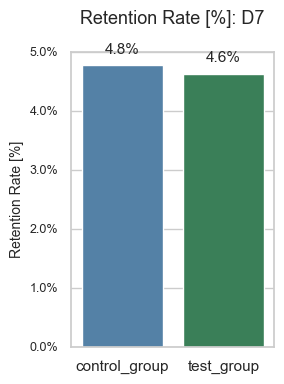

In [4]:
#retention = frvr_abtest.copy()

query_retention = f"""
      select 
          ab_group
        , count(distinct user_id) as users
        , count(distinct case when julianday(date) - julianday(acquisition_date) = 7 then user_id end) as retained_d7
    from frvr_user_events_raw
    where acquisition_date <= '2022-10-14'
    group by 1 order by 2,1 asc
"""

# Get df
retention = ps.sqldf(query_retention, locals())

# Calculate retention rate [%]
retention['retained_d7_pct'] = round(retention['retained_d7'] / retention['users'],4)*100

### Plot Data

# Set the style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(3, 4))
ax = sns.barplot(data=retention, x='ab_group', y='retained_d7_pct', palette=['steelblue', 'seagreen']
)

# Titles and labels
ax.set_title('Retention Rate [%]: D7', fontsize=13, pad=20)
ax.set_ylabel('Retention Rate [%]', fontsize=10)
ax.set_xlabel(None)
ax.set_ylim(0,5)

# Format Y-axis ticks with %
yticks = ax.get_yticks()
ax.set_yticklabels([f"{y:.1f}%" for y in yticks], fontsize=9)

# Annotate values on top of bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.2, f"{height:.1f}%", ha='center', fontsize=11)

plt.tight_layout()
plt.show()

#### 2. ARPU: D7 [€]: Control vs Test

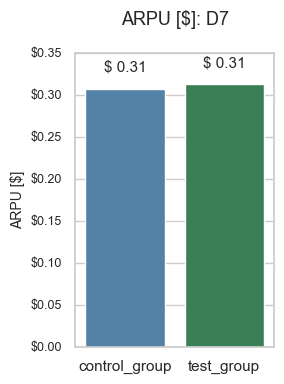

In [5]:
#arpu = frvr_abtest.copy()

query_arpu = f"""
      select 
          ab_group
        , count(distinct user_id) as users
        , sum(case when julianday(date) - julianday(acquisition_date) <= 7 then ad_revenue end) as cum_ad_revenue_d7
    from frvr_user_events_raw
    where acquisition_date <= '2022-10-14'
    group by 1 order by 2,1 asc
"""

# Get df
arpu = ps.sqldf(query_arpu, locals())

# Calculate retention rate [%]
arpu['arpu_d7'] = round(arpu['cum_ad_revenue_d7'] / arpu['users'],4)

### Plot Data

# Set the style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(3, 4))
ax = sns.barplot(data=arpu, x='ab_group', y='arpu_d7', palette=['steelblue', 'seagreen'])

# Titles and labels
ax.set_title('ARPU [$]: D7', fontsize=13, pad=20)
ax.set_ylabel('ARPU [$]', fontsize=10)
ax.set_xlabel(None)
ax.set_ylim(0,0.35)

# Format Y-axis ticks with %
yticks = ax.get_yticks()
ax.set_yticklabels([f"${y:.2f}" for y in yticks], fontsize=9)

# Annotate values on top of bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"$ {height:.2f}", ha='center', fontsize=11)

plt.tight_layout()
plt.show()

#### 3. Retention D1 - D7: Control vs Test

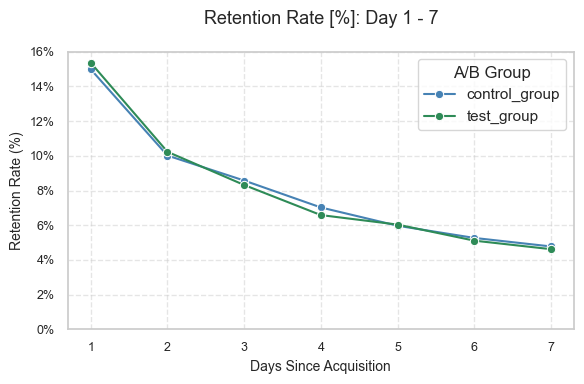

In [6]:
query_retention_d1_d7 = f"""
with users as (
      select 
          ab_group
        , julianday(date) - julianday(acquisition_date) as days_since_acquisition
        , count(distinct user_id) as users
    from frvr_user_events_raw
    where acquisition_date <= '2022-10-14'
    group by 1,2 order by 2,1 asc
),
users_retained as (
    select
          ab_group
        , days_since_acquisition
        , cast(users as real) users
        , cast(first_value(users) over (partition by ab_group) as real) as initial_users
        , cast(users as real) / cast(first_value(users) over (partition by ab_group) as real) as users_retained_pct
    from users
)
select * from users_retained
where days_since_acquisition between 1 and 7
"""

# Get df
retention_d1_d7 = ps.sqldf(query_retention_d1_d7, locals())
retention_d1_d7



# Seaborn line plot
plt.figure(figsize=(6, 4))
sns.lineplot(data=retention_d1_d7, x='days_since_acquisition', y='users_retained_pct',hue='ab_group', marker='o', palette=['steelblue', 'seagreen'])

# Formatting
plt.title('Retention Rate [%]: Day 1 - 7', fontsize=13, pad=20)
plt.xlabel('Days Since Acquisition', fontsize=10)
plt.ylabel('Retention Rate (%)', fontsize=10)
plt.xticks(fontsize=9)
plt.ylim(0,0.15)

# Format y-axis as percentage
yticks = plt.gca().get_yticks()
plt.yticks(yticks, [f"{y:.0%}" for y in yticks], fontsize=9)

plt.legend(title='A/B Group')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### 4. Stacked: Ad Impressions: Control vs Test

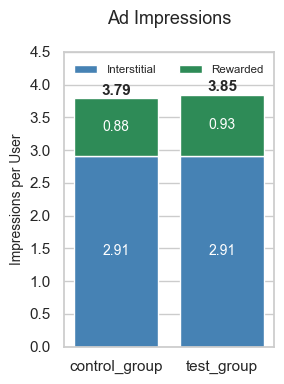

In [7]:
query_impressions = f"""
with impressions as (
      select 
          ab_group
        , sum(ad_impressions_interstitial) as ad_impressions_interstitial
        , sum(ad_impressions_rewarded) as ad_impressions_rewarded
        , count(distinct user_id) as users
    from frvr_user_events_raw
    where acquisition_date <= '2022-10-14'
        and julianday(date) - julianday(acquisition_date) <= 7 
    group by 1 order by 1 asc
)
select * from impressions
"""

impressions = ps.sqldf(query_impressions, locals())


# Step 1: Calculate impressions per user
impressions['interstitial_per_user'] = impressions['ad_impressions_interstitial'] / impressions['users']
impressions['rewarded_per_user'] = impressions['ad_impressions_rewarded'] / impressions['users']
impressions['total_per_user'] = impressions['interstitial_per_user'] + impressions['rewarded_per_user']

#impressions = impressions.set_index('ab_group')

# Step 2: Set up Seaborn styling
sns.set(style="whitegrid")

# Step 3: Plot
fig, ax = plt.subplots(figsize=(3, 4))

x = range(len(impressions))
interstitial = impressions['interstitial_per_user']
rewarded = impressions['rewarded_per_user']
labels = impressions['ab_group']

# Custom x-axis labels
labels = impressions['ab_group']

# Stacked bars
bars1 = ax.bar(x, interstitial, label='Interstitial', color='steelblue')
bars2 = ax.bar(x, rewarded, bottom=interstitial, label='Rewarded', color='seagreen')

# Add inner labels for each segment (2 decimal places)
for bar1, bar2 in zip(bars1, bars2):
    height1 = bar1.get_height()
    height2 = bar2.get_height()

    # Interstitial label
    ax.text(
        bar1.get_x() + bar1.get_width() / 2,
        height1 / 2,
        f"{height1:.2f}",
        ha='center', va='center', color='white', fontsize=10
    )

    # Rewarded label
    ax.text(
        bar2.get_x() + bar2.get_width() / 2,
        height1 + height2 / 2,
        f"{height2:.2f}",
        ha='center', va='center', color='white', fontsize=10
    )

# Add total label on top
for i, total in enumerate(impressions['total_per_user']):
    ax.text(i, total + 0.05, f"{total:.2f}", ha='center', fontsize=11, fontweight='bold')

# Axes & style
ax.set_xticks(x)
ax.set_ylabel("Impressions per User", fontsize=10)
ax.set_ylim(0,4.5)
ax.set_title("Ad Impressions", fontsize=13, pad=20)
ax.xaxis.grid(False)
ax.legend(loc='upper center', ncol=2,  bbox_to_anchor=(0.5, 0.99), frameon=False, fontsize='x-small') 
#ax.set_yticklabels(ax.get_yticks(), fontsize=9)
ax.set_xticklabels(labels)

plt.tight_layout()
plt.show()

In [8]:
impressions

,ab_group,ad_impressions_interstitial,ad_impressions_rewarded,users,interstitial_per_user,rewarded_per_user,total_per_user
0,control_group,61024,18441,20945,2.913535,0.880449,3.793984
1,test_group,61653,19723,21159,2.913796,0.932133,3.845928


In [9]:
#### 5. Summary Table
query = """
with users as (
      select
          ab_group
        , count(distinct user_id) as total_users
        , count(distinct 
            case 
                when acquisition_date <= '2022-10-14' 
                then user_id 
            end) as users_d7
        , count(distinct 
            case 
                when acquisition_date <= '2022-10-14' 
                    and julianday(date) - julianday(acquisition_date) = 7 
                then user_id 
            end) as users_retained_d7
        , sum(
            case 
                when acquisition_date <= '2022-10-14' 
                    and julianday(date) - julianday(acquisition_date) <= 7 
                then ad_revenue 
            end) as revenue_d7
        , sum(
            case
                when acquisition_date <= '2022-10-14' 
                    and julianday(date) - julianday(acquisition_date) <= 7 
                then ad_impressions_interstitial + ad_impressions_rewarded 
            end) as total_impressions_d7
    from frvr_user_events_raw
    group by 1
)
select * from users
"""

kpi_table = ps.sqldf(query, locals())


# Add KPI columns
kpi_table['impressions_per_user_d7'] = round(kpi_table['total_impressions_d7'] / kpi_table['users_d7'],2)
kpi_table['arpu_d7'] = round(kpi_table['revenue_d7'] / kpi_table['users_d7'],2)
kpi_table['retention_d7'] = round(kpi_table['users_retained_d7'] / kpi_table['users_d7'],3)

columns_to_keep = ['ab_group','total_users','users_d7','retention_d7','arpu_d7','impressions_per_user_d7']

kpi_table = kpi_table[columns_to_keep]

kpi_table

,ab_group,total_users,users_d7,retention_d7,arpu_d7,impressions_per_user_d7
0,control_group,42571,20945,0.048,0.31,3.79
1,test_group,42707,21159,0.046,0.31,3.85


In [10]:
kpi_table_t = kpi_table.set_index('ab_group').transpose()

kpi_table_t['∆'] = (kpi_table_t['test_group'] / kpi_table_t['control_group'] - 1).apply(lambda x: f"{round(x,3)}")

kpi_table_t

ab_group,control_group,test_group,∆
total_users,42571.000,42707.000,0.003
users_d7,20945.000,21159.000,0.01
retention_d7,0.048,0.046,-0.042
arpu_d7,0.310,0.310,0.0
impressions_per_user_d7,3.790,3.850,0.016
